<div style="color:#800080; font-size:28px; font-weight:bold;">
Título y datos del alumno    
</div>

**Título: Predección de incumplimiento de pago**
  
**Autores:**  
- Cisneros Lovaton, Sarai
- Urbina Castro, George

<div style="color:#800080; font-size:28px; font-weight:bold;">
    1. Introducción y Contexto del Negocio  
</div>

**Contexto**  
El Credit Risk Dataset es una base de datos simulada que contiene datos relacionados con solicitantes de préstamos: información personal, datos financieros y detalles del préstamo. Se requiere analizar y predecir el riesgo de crédito, es decir, determinar qué prestatarios tienen mayor probabilidad de incumplir el pago de un préstamo (default) en base a sus características financieras y personales. 


**Definición de variables:**

Variables Predictoras:
- person_age: Edad
- person_income: Ingresos anuales
- person_home_ownership: Tipo de propiedad de la vivienda
- person_emp_length: Antigüedad laboral (en años)
- loan_intent: Intención/motivo de préstamo
- loan_grade: Calificación/grado del préstamo (A a G en orden de riesgo)
- loan_amnt: Monto del préstamo solicitado
- loan_int_rate: Tasa de interés del préstamo
- loan_percent_income: Porcentaje de ingresos del préstamo (Relación entre el monto del préstamo y el ingreso del solicitante)
- cb_person_default_on_file: Historial de morosidad. ¿ha tenido incumplimientos anteriores en su historial de crédito? (sí/no).
- cb_person_cred_hist_length: Antigüedad del historial crediticio


Variable Objetivo (Target):
- loan_status: Estado del préstamo, donde:  

   0: No imcumplió el pago del prestamo (no default)  
   1: incumplió el pago del prestamo (default)


**Pregunta de negocio que intentas responder:**  
¿Puede construir un modelo de aprendizaje automático para predecir con precisión quienes tienen mayor probabilidad de incumplir el pago de un préstamo (default)?

**Matriz de Costos/Beneficios:**  

Antes de calcular ganancias, debemos definir cuánto vale cada decisión:

```
                    PREDICCIÓN
                 Negativo    Positivo
              ┌───────────┬───────────┐
    Negativo  │  TN: +500 │  FP: -100 │
REAL          ├───────────┼───────────┤
    Positivo  │ FN: -2000 │   TP: 0   │
              └───────────┴───────────┘
```

**Interpretación:**
- **Negativo = Buen Pagador** (Clase 0)
- **Positivo = Default** (Clase 1)


<div style="color:#800080; font-size:28px; font-weight:bold;">
    2. Carga de datos y Exploración de Datos
</div>

In [1]:
# 1. Configuración Inicial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Agregado para visualizaciones
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score, ConfusionMatrixDisplay, brier_score_loss, confusion_matrix
import joblib
import time
from sklearn.tree import DecisionTreeClassifier, plot_tree
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import os
import kagglehub
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
import optuna
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score

from category_encoders import TargetEncoder


# Implementación de calibration_curve (compatible con todas las versiones de sklearn)


def calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform"):
    """
    Calcula la curva de calibración.

    Parameters:
    -----------
    y_true : array-like - Etiquetas reales (0 o 1)
    y_prob : array-like - Probabilidades predichas
    n_bins : int - Número de bins para agrupar probabilidades
    strategy : str - 'uniform' (bins equidistantes) o 'quantile' (mismo # de muestras por bin)

    Returns:
    --------
    prob_true : array - Fracción real de positivos por bin
    prob_pred : array - Probabilidad media predicha por bin
    """
    y_true = np.asarray(y_true, dtype=float)
    y_prob = np.asarray(y_prob, dtype=float)

    if y_true.shape[0] != y_prob.shape[0]:
        raise ValueError("y_true y y_prob deben tener la misma longitud")
    if strategy not in {"uniform", "quantile"}:
        raise ValueError("strategy debe ser 'uniform' o 'quantile'")

    if strategy == "quantile":
        quantiles = np.linspace(0, 1, n_bins + 1)
        bins = np.quantile(y_prob, quantiles)
        bins[0], bins[-1] = 0.0, 1.0
        bins = np.unique(bins)
    else:
        bins = np.linspace(0, 1, n_bins + 1)

    bin_ids = np.digitize(y_prob, bins[1:-1], right=True)

    prob_true = []
    prob_pred = []
    for b in range(len(bins) - 1):
        mask = bin_ids == b
        if not np.any(mask):
            continue
        prob_true.append(y_true[mask].mean())
        prob_pred.append(y_prob[mask].mean())

    return np.array(prob_true), np.array(prob_pred)


print("✅ Librerías importadas correctamente.")



# Semilla aleatoria
RANDOM_STATE = 42



c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Librerías importadas correctamente.


In [2]:
!pip install kagglehub

In [3]:
# Cambiar ruta de almacenamiento
os.environ["KAGGLEHUB_CACHE"] = "../data/"
path = kagglehub.dataset_download("laotse/credit-risk-dataset")

print("Descargado en:", path)

Descargado en: ../data/datasets\laotse\credit-risk-dataset\versions\1


In [4]:
df = pd.read_csv("../data/datasets/laotse/credit-risk-dataset/versions/1/credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
# Ver columnas disponibles
print("Columnas:", df.columns.tolist()[:10], "...")
print(f"Dimensiones: {df.shape}")

# Separar Features y Target(loan_status)
TARGET_COL = 'loan_status'
COLS_TO_DROP = [TARGET_COL]

# Eliminamos explícitamente columnas que no aportan valor predictivo o son identificadores.
X = df.drop([col for col in COLS_TO_DROP if col in df.columns], axis=1)
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Distribución target (Train): {y_train.value_counts(normalize=True).to_dict()}")
print("")

X_train.info()


Columnas: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income'] ...
Dimensiones: (32581, 12)

Train shape: (26064, 11)
Test shape: (6517, 11)
Distribución target (Train): {0: 0.7818446899938613, 1: 0.21815531000613875}

<class 'pandas.core.frame.DataFrame'>
Index: 26064 entries, 15884 to 17068
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  26064 non-null  int64  
 1   person_income               26064 non-null  int64  
 2   person_home_ownership       26064 non-null  object 
 3   person_emp_length           25326 non-null  float64
 4   loan_intent                 26064 non-null  object 
 5   loan_grade                  26064 non-null  object 
 6   loan_amnt                   26064 non-null  int64  
 7   loan_int_rate               23563

<div style="color:#800080; font-size:28px; font-weight:bold;">
Explotación de Datos (EDA)
</div>

In [6]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Columnas Numéricas detectadas:", num_cols)

# columnas que en Pima usan 0 como indicador implícito de NA
suspect_zero_cols = [c for c in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI'] if c in num_cols]
print("")
print("Columnas donde 0 puede significar missing:", suspect_zero_cols)
print("")
for c in suspect_zero_cols:
    zeros = (X_train[c] == 0).sum()
    print(f"  {c}: zeros = {zeros} ({zeros/len(X_train)*100:.2f}%)")

Columnas Numéricas detectadas: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

Columnas donde 0 puede significar missing: []



In [7]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,26064.0,27.702732,6.327287,20.00,23.00,26.00,30.00,144.00
person_income,26064.0,66043.498235,63715.995292,4000.00,38443.25,55000.00,79000.00,6000000.00
person_emp_length,25326.0,4.794598,4.172469,0.00,2.00,4.00,7.00,123.00
loan_amnt,26064.0,9569.114487,6295.931312,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,23563.0,11.015630,3.235240,5.42,7.90,10.99,13.47,22.48
loan_percent_income,26064.0,0.170179,0.106807,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,26064.0,5.786641,4.034795,2.00,3.00,4.00,8.00,30.00


In [8]:
# Identificar tipos de columnas automáticamente
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Features numéricas ({len(num_features)}): {num_features[:10]}...")
print(f"Features categóricas ({len(cat_features)}): {cat_features[:10] if cat_features else 'Ninguna'}")

# Verificar valores nulos
null_pct = (X_train.isnull().sum() / len(X_train)
            * 100).sort_values(ascending=False)
print(f"\nColumnas con más nulos:\n{null_pct.head()}")

Features numéricas (7): ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']...
Features categóricas (4): ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

Columnas con más nulos:
loan_int_rate            9.595611
person_emp_length        2.831492
person_age               0.000000
person_home_ownership    0.000000
person_income            0.000000
dtype: float64


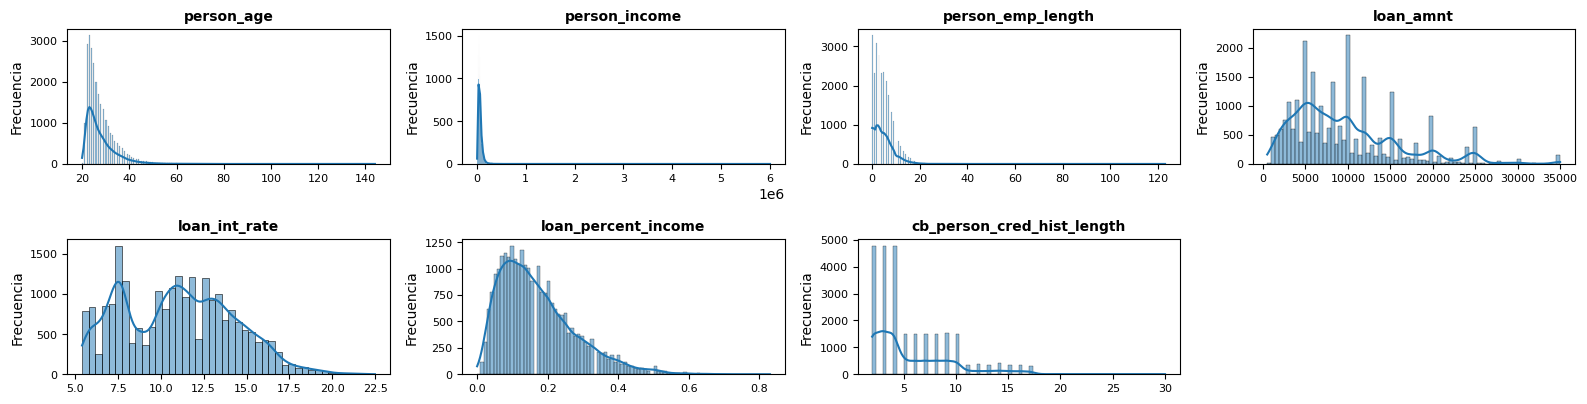

In [9]:
def plot_numeric_distributions(x):
    # Seleccionar columnas numéricas
    columnas_numeric = num_features #x.select_dtypes(include=['float64', 'int64']).columns

    # Número de variables numéricas
    num_vars = len(columnas_numeric)

    # Calcular el número de filas y columnas
    ncols = 4
    nrows = int(np.ceil(num_vars / ncols))

    # Crear subgráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 2))
    axes = axes.flatten()  # Aplanar la matriz de ejes para fácil indexación

    # Graficar histogramas
    for i, colum in enumerate(columnas_numeric):
        sns.histplot(data=x, x=colum, kde=True, ax=axes[i])
        axes[i].set_title(colum, fontsize=10, fontweight="bold")
        axes[i].tick_params(labelsize=8)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Frecuencia")

    # Ocultar ejes extra
    for ax in axes[num_vars:]:
        ax.axis('off')

    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    #fig.suptitle('Distribución de variables numéricas', fontsize=12, fontweight="bold")
    plt.show()

plot_numeric_distributions(X_train)

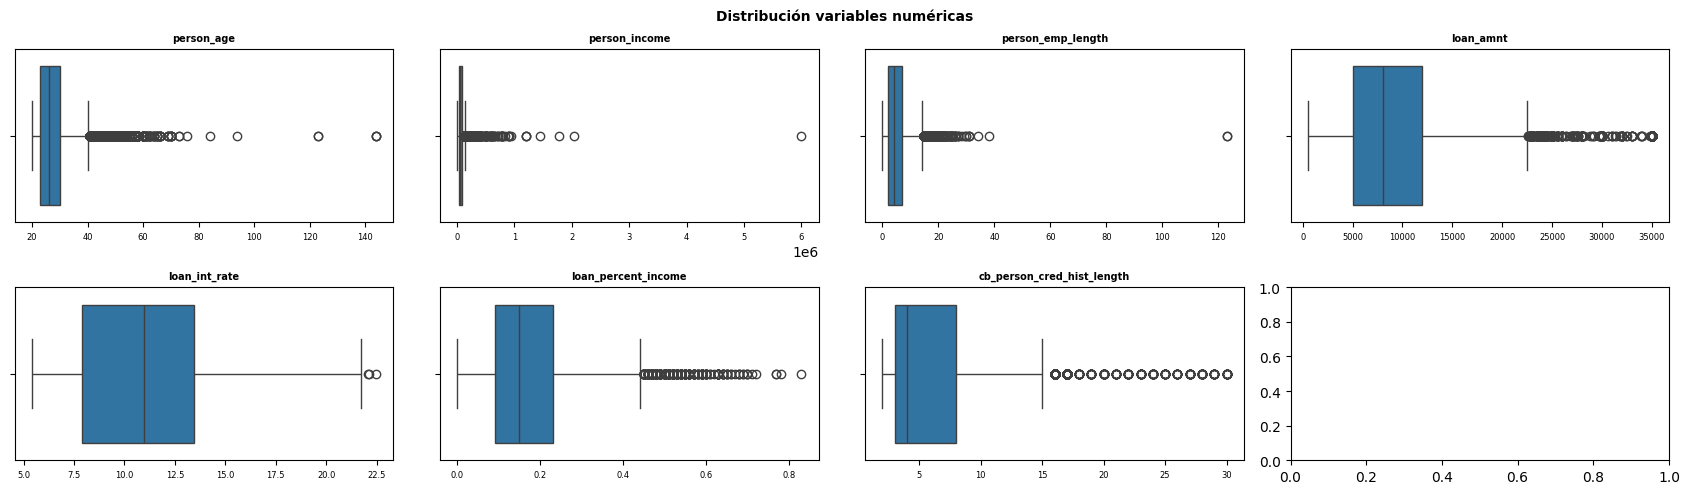

In [10]:
# Ajustar el número de subplots en función del número de columnas numéricas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17, 5))
axes = axes.flat
columnas_numeric = num_features #df.select_dtypes(include=['float64', 'int64']).drop(columns=['Outcome']).columns

for i, colum in enumerate(columnas_numeric):
    sns.boxplot(data=X_train, x=colum, ax=axes[i])
    axes[i].set_title(colum, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables numéricas', fontsize=10, fontweight="bold")
plt.show()

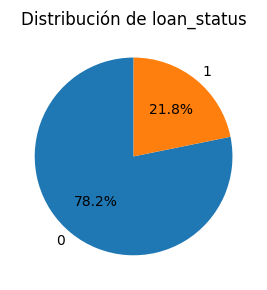

In [11]:
conteo = y_train.value_counts()

plt.figure(figsize=(3,3))
plt.pie(
    conteo.values,
    labels=conteo.index,
    autopct='%1.1f%%',
    startangle=90
)

plt.title("Distribución de loan_status")
plt.tight_layout()
plt.show()

<div style="color:#800080; font-size:28px; font-weight:bold;">
3. Preprocesamiento (Pipeline) y modelo base
</div>

In [12]:
cols_validar_ceros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
cols_no_validar_ceros = ['Pregnancies','DiabetesPedigreeFunction','Age']


# Pipeline Numérico: Imputación + Escalado
pipeline_num = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline Categórico (Placeholder por si hubiera)
# Nota: TargetEncoder de category_encoders usa 'min_samples_leaf' en lugar de 'smoothing'
pipeline_categ = Pipeline([
    # ✅ SOLUCIÓN ANTI-PATTERN 1 (Reproducibilidad):
    # Si llega un nulo en producción, lo llenamos con 'missing' automáticamente.
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),

    # ✅ SOLUCIÓN ANTI-PATTERN 2 (Fragilidad):
    # TargetEncoder (o OneHotEncoder) maneja categorías nuevas en test/producción sin romper el código.
    ('encoder', TargetEncoder(min_samples_leaf=10))
])




In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('pipeline_numerico', pipeline_num, num_features),
        ('pipeline_categorico', pipeline_categ, cat_features)
    ],
    verbose_feature_names_out=False,
    remainder='drop'  # Lo que no listamos, se borra
)

# Visualizar el preprocesador (sin ajustar aún)
preprocessor



,transformers,"[('pipeline_numerico', ...), ('pipeline_categorico', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


<div style="color:#800080; font-size:28px; font-weight:bold;">
    Entrenamiento de Modelos
</div>

Se configuran 5 modelos: Arbol Simple, Random Forest, Gradient Boosting, XGBoost y SVM
Con hiperparametros por defecto

Se definieron pipelines de clasificación que integran el preprocesamiento de los datos con distintos modelos de aprendizaje automático. En esta etapa, unicamente se especifican los modelos con sus hiperparametros por defecto, sin realizar aún el entrenamiento ni la evaluación.

In [14]:
model_RandomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

model_Gradient = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

model_XGBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=RANDOM_STATE))
])

model_Light = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=RANDOM_STATE))
])




Luego, realizamos el entrenamiento y evaluación de los 5 modelos. Para cada modelo calculamos métricas de desempeño (Accuraci, AUC, Recall de la clase 1), asi como el tiempo de entrenamiento, las cuales serán necesarias para su comparación y análisis posterior.

In [15]:
# Modelos a comparar
modelos = {    
    'Random Forest': model_RandomForest,
    'Gradient Boosting': model_Gradient,
    'XGBoost': model_XGBoost,
    'Light': model_Light
}

resultados_comparacion = []

for nombre, modelo in modelos.items():
    start_time = time.time() # tiempo de inicio
    modelo.fit(X_train, y_train) # entrenamiento
    time_result = time.time() - start_time # tiempo de término

    y_pred = modelo.predict(X_test) # pred    
    y_proba = modelo.predict_proba(X_test)[:, 1]
    
    resultados_comparacion.append({
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba),
        'Recall_Clase_1': recall_score(y_test, y_pred),
        'Tiempo (s)': time_result
    })

[LightGBM] [Info] Number of positive: 5686, number of negative: 20378
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 953
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218155 -> initscore=-1.276449
[LightGBM] [Info] Start training from score -1.276449


c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


<div style="color:#800080; font-size:28px; font-weight:bold;">
    Métricas
</div>

In [16]:
# Crear DataFrame de resultados
df_results = pd.DataFrame(resultados_comparacion)
df_results['Accuracy'] = df_results['Accuracy'].round(4)
df_results['AUC'] = df_results['AUC'].round(4)
df_results['Recall_Clase_1'] = df_results['Recall_Clase_1'].round(4)  #agregado
df_results['Tiempo (s)'] = df_results['Tiempo (s)'].round(3)

# Identificar ganadores
best_auc_idx = df_results['AUC'].idxmax()
fastest_idx = df_results['Tiempo (s)'].idxmin()
best_recall_idx = df_results['Recall_Clase_1'].idxmax()  #agregado

print("=" * 65)
print("🏆 TABLA DE RESULTADOS")
print("=" * 65)
print(df_results.to_string(index=False))
print("\n")
print(f"🥇 Mejor Recall (Clase 1): {df_results.loc[best_recall_idx, 'Modelo']} ({df_results.loc[best_recall_idx, 'Recall_Clase_1']:.4f})")  #agregado
print(f"🥇 Mejor AUC: {df_results.loc[best_auc_idx, 'Modelo']} ({df_results.loc[best_auc_idx, 'AUC']:.4f})")
print(f"⚡ Más Rápido: {df_results.loc[fastest_idx, 'Modelo']} ({df_results.loc[fastest_idx, 'Tiempo (s)']:.2f}s)")

🏆 TABLA DE RESULTADOS
           Modelo  Accuracy    AUC  Recall_Clase_1  Tiempo (s)
    Random Forest    0.9337 0.9316          0.7117       1.947
Gradient Boosting    0.9270 0.9279          0.6969       1.925
          XGBoost    0.9340 0.9491          0.7293       0.360
            Light    0.9354 0.9482          0.7215       2.138


🥇 Mejor Recall (Clase 1): XGBoost (0.7293)
🥇 Mejor AUC: XGBoost (0.9491)
⚡ Más Rápido: XGBoost (0.36s)


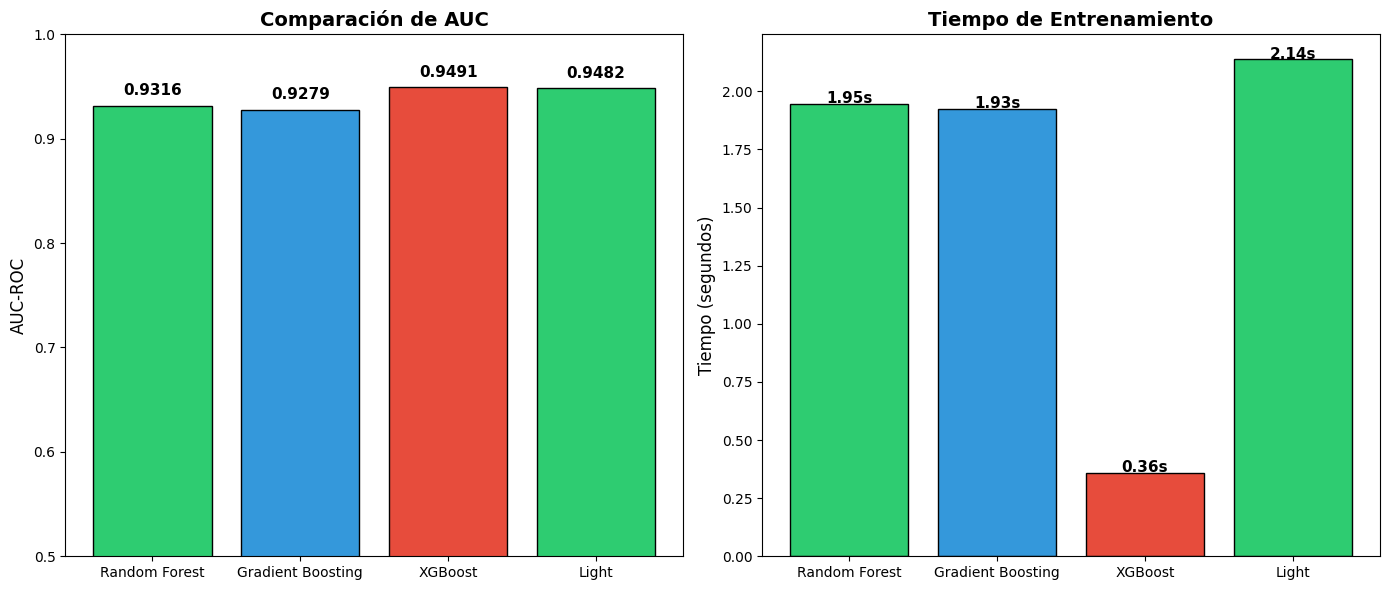

In [17]:
# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#2ecc71', '#3498db', '#e74c3c']  # Verde, Azul, Rojo

# Gráfico 1: AUC
ax1 = axes[0]
bars1 = ax1.bar(df_results['Modelo'], df_results['AUC'],
                color=colors, edgecolor='black')
ax1.set_ylabel('AUC-ROC', fontsize=12)
ax1.set_title('Comparación de AUC', fontsize=14, fontweight='bold')
ax1.set_ylim(0.5, 1.0)
for bar, val in zip(bars1, df_results['AUC']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

# Gráfico 2: Tiempo
ax2 = axes[1]
bars2 = ax2.bar(
    df_results['Modelo'], df_results['Tiempo (s)'], color=colors, edgecolor='black')
ax2.set_ylabel('Tiempo (segundos)', fontsize=12)
ax2.set_title('Tiempo de Entrenamiento', fontsize=14, fontweight='bold')
for bar, val in zip(bars2, df_results['Tiempo (s)']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{val:.2f}s', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


[LightGBM] [Info] Number of positive: 6397, number of negative: 22925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 29322, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218164 -> initscore=-1.276399
[LightGBM] [Info] Start training from score -1.276399


c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6397, number of negative: 22926
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 966
[LightGBM] [Info] Number of data points in the train set: 29323, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218156 -> initscore=-1.276443
[LightGBM] [Info] Start training from score -1.276443


c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6397, number of negative: 22926
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 967
[LightGBM] [Info] Number of data points in the train set: 29323, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218156 -> initscore=-1.276443
[LightGBM] [Info] Start training from score -1.276443
[LightGBM] [Info] Number of positive: 6397, number of negative: 22926
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 29323, number of used features: 11
[LightGBM] [Info] [bin

c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6397, number of negative: 22926
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 29323, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218156 -> initscore=-1.276443
[LightGBM] [Info] Start training from score -1.276443


c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6397, number of negative: 22926
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 29323, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218156 -> initscore=-1.276443
[LightGBM] [Info] Start training from score -1.276443


c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6397, number of negative: 22926
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 964
[LightGBM] [Info] Number of data points in the train set: 29323, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218156 -> initscore=-1.276443
[LightGBM] [Info] Start training from score -1.276443
[LightGBM] [Info] Number of positive: 6397, number of negative: 22926
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 29323, number of used features: 11
[LightGBM] [Info] [bin

c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6398, number of negative: 22925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 29323, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218190 -> initscore=-1.276243
[LightGBM] [Info] Start training from score -1.276243


c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6398, number of negative: 22925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 29323, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218190 -> initscore=-1.276243
[LightGBM] [Info] Start training from score -1.276243


c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


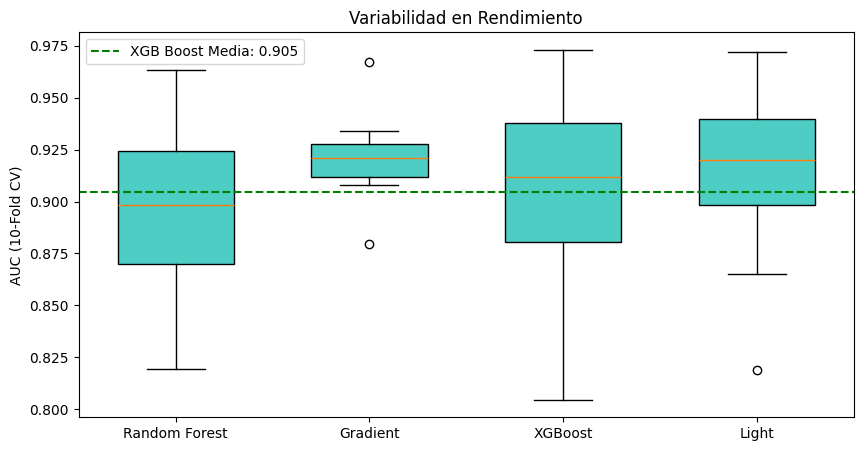

📊 Random_Forest:    0.897 ± 0.045
📊 Gradient:    0.921 ± 0.021
📊 XGBoost:    0.905 ± 0.047
📊 Light:    0.912 ± 0.042


In [18]:
# Comparar estabilidad con Cross-Validation
rf_scores = cross_val_score(model_RandomForest, X, y, cv=10, scoring='roc_auc')
gradient_scores = cross_val_score(model_Gradient, X, y, cv=10, scoring='roc_auc')
xgboost_scores = cross_val_score(model_XGBoost, X, y, cv=10, scoring='roc_auc')
light_scores = cross_val_score(model_Light, X, y, cv=10, scoring='roc_auc')

fig, ax = plt.subplots(figsize=(10, 5))
positions = [1, 2, 3, 4]
bp = ax.boxplot([rf_scores, gradient_scores, xgboost_scores, light_scores], positions=positions, widths=0.6, patch_artist=True)

colors = ['#4ECDC4', '#4ECDC4', '#4ECDC4', '#4ECDC4']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xticks(positions)
ax.set_xticklabels(['Random Forest', 'Gradient', 'XGBoost','Light'])
ax.set_ylabel('AUC (10-Fold CV)')
ax.set_title('Variabilidad en Rendimiento')
ax.axhline(y=np.mean(xgboost_scores), color='green', linestyle='--',
           label=f'XGB Boost Media: {np.mean(xgboost_scores):.3f}')
ax.legend()
plt.show()

print(f"📊 Random_Forest:    {np.mean(rf_scores):.3f} ± {np.std(rf_scores):.3f}")
print(f"📊 Gradient:    {np.mean(gradient_scores):.3f} ± {np.std(gradient_scores):.3f}")
print(f"📊 XGBoost:    {np.mean(xgboost_scores):.3f} ± {np.std(xgboost_scores):.3f}")
print(f"📊 Light:    {np.mean(light_scores):.3f} ± {np.std(light_scores):.3f}")


Considerando que el estudio quiere detectar con precisión si los pacientes tienen diabetes o no, el modelo con mejor desempeño es Gradient Boosting.  

Razones:
- mayor AUC (0.7406), mejor discrimina entre pacientes con y sin diabetes
- mayor recall de clase 1 (0.6111) detecta mejor a los pacientes con diabetes, y por tanto es menor los falsos negativos
- menor tiempo de entrenamiento (0.115 s), buen equilibrio entre rendimiento y costo computacional

<div style="color:#800080; font-size:28px; font-weight:bold;">
    4. Optimización de Optuna    
</div>

In [19]:
# Ejemplo de estructura esperada

def objective(trial):

    # 1. Definir el espacio de búsqueda
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),               # agregado
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),                             # agregado
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),               # agregado
        'eval_metric': 'auc',                                                           # agregado
        'random_state': RANDOM_STATE                                                        # agregado
    }
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(**params))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    aucs = []

    for fold, (tr, val) in enumerate(cv.split(X_train, y_train)):
        model.fit(X_train.iloc[tr], y_train.iloc[tr])
        y_proba = model.predict_proba(X_train.iloc[val])[:, 1]
        auc = roc_auc_score(y_train.iloc[val], y_proba)
        aucs.append(auc)

        # 👇 pruning real
        trial.report(np.mean(aucs), step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(aucs)

# Crear el estudio de optimización
#study = optuna.create_study(direction='maximize')
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

# Ejecutar optimización (20 trials para el ejemplo, en producción usar 50-100)
study.optimize(objective, n_trials=50, show_progress_bar=True)


print("\n🎉 ¡Optimización terminada!")
print(f"🏆 Mejor AUC (CV): {study.best_value:.4f}")
print(f"⚙️ Mejores parámetros:")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")


[I 2025-12-15 08:46:03,195] A new study created in memory with name: no-name-fc82af6a-dc11-43a5-b4ef-49bd42c5c338
Best trial: 0. Best value: 0.907597:   2%|▏         | 1/50 [00:00<00:43,  1.13it/s]

[I 2025-12-15 08:46:04,078] Trial 0 finished with value: 0.9075969666558639 and parameters: {'n_estimators': 151, 'max_depth': 3, 'learning_rate': 0.01331186872105412, 'subsample': 0.7099271105569294, 'colsample_bytree': 0.9033717475287527}. Best is trial 0 with value: 0.9075969666558639.


Best trial: 1. Best value: 0.908488:   4%|▍         | 2/50 [00:01<00:45,  1.05it/s]

[I 2025-12-15 08:46:05,081] Trial 1 finished with value: 0.9084880356234166 and parameters: {'n_estimators': 187, 'max_depth': 3, 'learning_rate': 0.012519699126825356, 'subsample': 0.8686665702630443, 'colsample_bytree': 0.7779057175313462}. Best is trial 1 with value: 0.9084880356234166.


Best trial: 2. Best value: 0.942633:   6%|▌         | 3/50 [00:04<01:10,  1.51s/it]

[I 2025-12-15 08:46:07,247] Trial 2 finished with value: 0.9426327031076497 and parameters: {'n_estimators': 424, 'max_depth': 5, 'learning_rate': 0.03319129666106709, 'subsample': 0.7900710009955971, 'colsample_bytree': 0.7269186598281543}. Best is trial 2 with value: 0.9426327031076497.


Best trial: 3. Best value: 0.944728:   8%|▊         | 4/50 [00:06<01:34,  2.07s/it]

[I 2025-12-15 08:46:10,167] Trial 3 finished with value: 0.944728219267143 and parameters: {'n_estimators': 412, 'max_depth': 6, 'learning_rate': 0.03523988172626431, 'subsample': 0.7034371114158657, 'colsample_bytree': 0.7665070726747399}. Best is trial 3 with value: 0.944728219267143.


Best trial: 3. Best value: 0.944728:  10%|█         | 5/50 [00:09<01:46,  2.36s/it]

[I 2025-12-15 08:46:13,044] Trial 4 finished with value: 0.9387910031743052 and parameters: {'n_estimators': 371, 'max_depth': 6, 'learning_rate': 0.01543218282601982, 'subsample': 0.8851232839434335, 'colsample_bytree': 0.9555523817679125}. Best is trial 3 with value: 0.944728219267143.


Best trial: 3. Best value: 0.944728:  12%|█▏        | 6/50 [00:10<01:15,  1.71s/it]

[I 2025-12-15 08:46:13,492] Trial 5 pruned. 


Best trial: 3. Best value: 0.944728:  14%|█▍        | 7/50 [00:15<01:55,  2.69s/it]

[I 2025-12-15 08:46:18,204] Trial 6 finished with value: 0.9425262293930683 and parameters: {'n_estimators': 461, 'max_depth': 9, 'learning_rate': 0.014847758388491233, 'subsample': 0.640694772979156, 'colsample_bytree': 0.7243092097327738}. Best is trial 3 with value: 0.944728219267143.


Best trial: 3. Best value: 0.944728:  16%|█▌        | 8/50 [00:17<01:45,  2.50s/it]

[I 2025-12-15 08:46:20,310] Trial 7 finished with value: 0.9446888621964191 and parameters: {'n_estimators': 197, 'max_depth': 7, 'learning_rate': 0.0967572093059788, 'subsample': 0.7020486189788566, 'colsample_bytree': 0.7132763132155391}. Best is trial 3 with value: 0.944728219267143.


Best trial: 3. Best value: 0.944728:  18%|█▊        | 9/50 [00:17<01:18,  1.91s/it]

[I 2025-12-15 08:46:20,927] Trial 8 pruned. 


Best trial: 9. Best value: 0.945358:  20%|██        | 10/50 [00:20<01:32,  2.31s/it]

[I 2025-12-15 08:46:24,108] Trial 9 finished with value: 0.9453580413451806 and parameters: {'n_estimators': 410, 'max_depth': 6, 'learning_rate': 0.03707743643979063, 'subsample': 0.674585732063981, 'colsample_bytree': 0.9528613817504402}. Best is trial 9 with value: 0.9453580413451806.


Best trial: 9. Best value: 0.945358:  22%|██▏       | 11/50 [00:21<01:09,  1.79s/it]

[I 2025-12-15 08:46:24,740] Trial 10 pruned. 


Best trial: 9. Best value: 0.945358:  24%|██▍       | 12/50 [00:22<00:53,  1.40s/it]

[I 2025-12-15 08:46:25,250] Trial 11 pruned. 


Best trial: 12. Best value: 0.946657:  26%|██▌       | 13/50 [00:24<01:04,  1.75s/it]

[I 2025-12-15 08:46:27,800] Trial 12 finished with value: 0.946656867921187 and parameters: {'n_estimators': 296, 'max_depth': 6, 'learning_rate': 0.06202337096527983, 'subsample': 0.7801323470627538, 'colsample_bytree': 0.9805930762189419}. Best is trial 12 with value: 0.946656867921187.


Best trial: 12. Best value: 0.946657:  28%|██▊       | 14/50 [00:27<01:11,  1.98s/it]

[I 2025-12-15 08:46:30,298] Trial 13 finished with value: 0.9455794985095747 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.07478986732712001, 'subsample': 0.7822727443470051, 'colsample_bytree': 0.9927416737564252}. Best is trial 12 with value: 0.946656867921187.


Best trial: 12. Best value: 0.946657:  30%|███       | 15/50 [00:29<01:11,  2.05s/it]

[I 2025-12-15 08:46:32,528] Trial 14 finished with value: 0.9462559809612328 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.0823790391106986, 'subsample': 0.7766325115805116, 'colsample_bytree': 0.9900276916923689}. Best is trial 12 with value: 0.946656867921187.


Best trial: 12. Best value: 0.946657:  32%|███▏      | 16/50 [00:31<01:09,  2.05s/it]

[I 2025-12-15 08:46:34,566] Trial 15 finished with value: 0.9460913878031987 and parameters: {'n_estimators': 294, 'max_depth': 4, 'learning_rate': 0.10928906227937148, 'subsample': 0.8467341496100836, 'colsample_bytree': 0.882399786995399}. Best is trial 12 with value: 0.946656867921187.


Best trial: 12. Best value: 0.946657:  34%|███▍      | 17/50 [00:31<00:50,  1.53s/it]

[I 2025-12-15 08:46:34,895] Trial 16 pruned. 


Best trial: 12. Best value: 0.946657:  36%|███▌      | 18/50 [00:32<00:41,  1.29s/it]

[I 2025-12-15 08:46:35,622] Trial 17 pruned. 


Best trial: 12. Best value: 0.946657:  38%|███▊      | 19/50 [00:34<00:48,  1.56s/it]

[I 2025-12-15 08:46:37,804] Trial 18 finished with value: 0.9463619959133436 and parameters: {'n_estimators': 327, 'max_depth': 4, 'learning_rate': 0.20229614288527098, 'subsample': 0.9079740352019006, 'colsample_bytree': 0.8720771669870504}. Best is trial 12 with value: 0.946656867921187.


Best trial: 12. Best value: 0.946657:  40%|████      | 20/50 [00:36<00:51,  1.71s/it]

[I 2025-12-15 08:46:39,879] Trial 19 finished with value: 0.9452249618771413 and parameters: {'n_estimators': 322, 'max_depth': 4, 'learning_rate': 0.26184385948117844, 'subsample': 0.9398418399328367, 'colsample_bytree': 0.8666615231925009}. Best is trial 12 with value: 0.946656867921187.


Best trial: 12. Best value: 0.946657:  42%|████▏     | 21/50 [00:37<00:38,  1.34s/it]

[I 2025-12-15 08:46:40,350] Trial 20 pruned. 


Best trial: 12. Best value: 0.946657:  44%|████▍     | 22/50 [00:37<00:30,  1.10s/it]

[I 2025-12-15 08:46:40,878] Trial 21 pruned. 


Best trial: 12. Best value: 0.946657:  46%|████▌     | 23/50 [00:38<00:23,  1.13it/s]

[I 2025-12-15 08:46:41,265] Trial 22 pruned. 


Best trial: 12. Best value: 0.946657:  48%|████▊     | 24/50 [00:40<00:33,  1.30s/it]

[I 2025-12-15 08:46:43,540] Trial 23 finished with value: 0.9461152759690705 and parameters: {'n_estimators': 221, 'max_depth': 7, 'learning_rate': 0.055294680209605554, 'subsample': 0.8206069274455577, 'colsample_bytree': 0.8653177687482901}. Best is trial 12 with value: 0.946656867921187.


Best trial: 12. Best value: 0.946657:  50%|█████     | 25/50 [00:40<00:27,  1.08s/it]

[I 2025-12-15 08:46:44,117] Trial 24 pruned. 


Best trial: 12. Best value: 0.946657:  52%|█████▏    | 26/50 [00:41<00:21,  1.13it/s]

[I 2025-12-15 08:46:44,539] Trial 25 pruned. 


Best trial: 12. Best value: 0.946657:  54%|█████▍    | 27/50 [00:41<00:17,  1.34it/s]

[I 2025-12-15 08:46:44,957] Trial 26 pruned. 


Best trial: 12. Best value: 0.946657:  56%|█████▌    | 28/50 [00:42<00:16,  1.33it/s]

[I 2025-12-15 08:46:45,730] Trial 27 pruned. 


Best trial: 12. Best value: 0.946657:  58%|█████▊    | 29/50 [00:42<00:13,  1.51it/s]

[I 2025-12-15 08:46:46,180] Trial 28 pruned. 


Best trial: 12. Best value: 0.946657:  60%|██████    | 30/50 [00:43<00:11,  1.76it/s]

[I 2025-12-15 08:46:46,529] Trial 29 pruned. 


Best trial: 12. Best value: 0.946657:  62%|██████▏   | 31/50 [00:43<00:10,  1.86it/s]

[I 2025-12-15 08:46:47,000] Trial 30 pruned. 


Best trial: 12. Best value: 0.946657:  64%|██████▍   | 32/50 [00:44<00:09,  1.92it/s]

[I 2025-12-15 08:46:47,476] Trial 31 pruned. 


Best trial: 12. Best value: 0.946657:  66%|██████▌   | 33/50 [00:46<00:19,  1.16s/it]

[I 2025-12-15 08:46:50,141] Trial 32 finished with value: 0.9465166289633468 and parameters: {'n_estimators': 231, 'max_depth': 8, 'learning_rate': 0.05979434840523589, 'subsample': 0.8904497609764279, 'colsample_bytree': 0.854683318876278}. Best is trial 12 with value: 0.946656867921187.


Best trial: 12. Best value: 0.946657:  68%|██████▊   | 34/50 [00:47<00:15,  1.06it/s]

[I 2025-12-15 08:46:50,565] Trial 33 pruned. 


Best trial: 12. Best value: 0.946657:  70%|███████   | 35/50 [00:48<00:13,  1.12it/s]

[I 2025-12-15 08:46:51,334] Trial 34 pruned. 


Best trial: 12. Best value: 0.946657:  72%|███████▏  | 36/50 [00:48<00:10,  1.39it/s]

[I 2025-12-15 08:46:51,661] Trial 35 pruned. 


Best trial: 12. Best value: 0.946657:  74%|███████▍  | 37/50 [00:50<00:15,  1.23s/it]

[I 2025-12-15 08:46:54,073] Trial 36 finished with value: 0.9463284113388882 and parameters: {'n_estimators': 331, 'max_depth': 5, 'learning_rate': 0.08713034447495478, 'subsample': 0.8458538366541166, 'colsample_bytree': 0.8989656985318238}. Best is trial 12 with value: 0.946656867921187.


Best trial: 12. Best value: 0.946657:  76%|███████▌  | 38/50 [00:51<00:12,  1.04s/it]

[I 2025-12-15 08:46:54,666] Trial 37 pruned. 


Best trial: 12. Best value: 0.946657:  78%|███████▊  | 39/50 [00:52<00:11,  1.04s/it]

[I 2025-12-15 08:46:55,717] Trial 38 pruned. 


Best trial: 39. Best value: 0.946904:  80%|████████  | 40/50 [00:56<00:19,  1.93s/it]

[I 2025-12-15 08:46:59,734] Trial 39 finished with value: 0.9469040123732464 and parameters: {'n_estimators': 401, 'max_depth': 8, 'learning_rate': 0.03512707580841596, 'subsample': 0.916170978275879, 'colsample_bytree': 0.8577695557473813}. Best is trial 39 with value: 0.9469040123732464.


Best trial: 39. Best value: 0.946904:  82%|████████▏ | 41/50 [00:57<00:14,  1.62s/it]

[I 2025-12-15 08:47:00,615] Trial 40 pruned. 


Best trial: 39. Best value: 0.946904:  84%|████████▍ | 42/50 [01:01<00:17,  2.23s/it]

[I 2025-12-15 08:47:04,281] Trial 41 finished with value: 0.9468145931432316 and parameters: {'n_estimators': 396, 'max_depth': 7, 'learning_rate': 0.03760042177789785, 'subsample': 0.9204055584909117, 'colsample_bytree': 0.8116367559087592}. Best is trial 39 with value: 0.9469040123732464.


Best trial: 39. Best value: 0.946904:  86%|████████▌ | 43/50 [01:05<00:20,  2.90s/it]

[I 2025-12-15 08:47:08,752] Trial 42 finished with value: 0.9465944116579713 and parameters: {'n_estimators': 391, 'max_depth': 9, 'learning_rate': 0.03588381583513781, 'subsample': 0.9169888231288404, 'colsample_bytree': 0.8081667850142202}. Best is trial 39 with value: 0.9469040123732464.


Best trial: 39. Best value: 0.946904:  88%|████████▊ | 44/50 [01:11<00:22,  3.74s/it]

[I 2025-12-15 08:47:14,434] Trial 43 finished with value: 0.9468243454422425 and parameters: {'n_estimators': 495, 'max_depth': 9, 'learning_rate': 0.0314632451626601, 'subsample': 0.9344199225589158, 'colsample_bytree': 0.7530261324152893}. Best is trial 39 with value: 0.9469040123732464.


Best trial: 39. Best value: 0.946904:  90%|█████████ | 45/50 [01:16<00:21,  4.25s/it]

[I 2025-12-15 08:47:19,862] Trial 44 finished with value: 0.9468277065462175 and parameters: {'n_estimators': 498, 'max_depth': 9, 'learning_rate': 0.0319319472728991, 'subsample': 0.9372096186871054, 'colsample_bytree': 0.7500864284332435}. Best is trial 39 with value: 0.9469040123732464.


Best trial: 45. Best value: 0.94709:  92%|█████████▏| 46/50 [01:22<00:18,  4.66s/it] 

[I 2025-12-15 08:47:25,485] Trial 45 finished with value: 0.9470899703798533 and parameters: {'n_estimators': 496, 'max_depth': 9, 'learning_rate': 0.03038421309506929, 'subsample': 0.9361361346915107, 'colsample_bytree': 0.7610069694812103}. Best is trial 45 with value: 0.9470899703798533.


Best trial: 45. Best value: 0.94709:  94%|█████████▍| 47/50 [01:28<00:15,  5.05s/it]

[I 2025-12-15 08:47:31,453] Trial 46 finished with value: 0.9469323847763225 and parameters: {'n_estimators': 496, 'max_depth': 9, 'learning_rate': 0.03004199807806646, 'subsample': 0.9411744627419307, 'colsample_bytree': 0.7492207006468629}. Best is trial 45 with value: 0.9470899703798533.


Best trial: 45. Best value: 0.94709:  96%|█████████▌| 48/50 [01:33<00:10,  5.11s/it]

[I 2025-12-15 08:47:36,697] Trial 47 finished with value: 0.9467889441418093 and parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.03005519030059327, 'subsample': 0.9487289434186676, 'colsample_bytree': 0.7406928189129909}. Best is trial 45 with value: 0.9470899703798533.


Best trial: 45. Best value: 0.94709:  98%|█████████▊| 49/50 [01:34<00:03,  3.91s/it]

[I 2025-12-15 08:47:37,818] Trial 48 pruned. 


Best trial: 45. Best value: 0.94709: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]

[I 2025-12-15 08:47:42,884] Trial 49 finished with value: 0.9469491663019756 and parameters: {'n_estimators': 497, 'max_depth': 9, 'learning_rate': 0.02741738864326251, 'subsample': 0.9334521850242249, 'colsample_bytree': 0.7533950561957228}. Best is trial 45 with value: 0.9470899703798533.

🎉 ¡Optimización terminada!
🏆 Mejor AUC (CV): 0.9471
⚙️ Mejores parámetros:
   n_estimators: 496
   max_depth: 9
   learning_rate: 0.03038421309506929
   subsample: 0.9361361346915107
   colsample_bytree: 0.7610069694812103


### 📊 Visualizando la Optimización

In [20]:
# Historia de la optimización: ¿Mejoramos con el tiempo?
optuna.visualization.plot_optimization_history(study)
    

In [21]:
# Importancia de Hiperparámetros: ¿Qué movió la aguja?
optuna.visualization.plot_param_importances(study)

### Entrenemos el modelo final con los mejores parámetros

In [22]:
# Entrenar modelo final con los mejores hiperparámetros de Optuna
best_params = study.best_params
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
    **best_params,
    random_state=RANDOM_STATE
    ))
])
model.fit(X_train, y_train)

# ✅ SOLUCIÓN ANTI-PATTERN 5 (Evaluar en Train):

# Evaluamos SIEMPRE sobre el conjunto de TEST (datos que el modelo nunca vio)
y_prob = model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_prob)

print(f"✅ Modelo final entrenado con los mejores hiperparámetros")
print(f"📊 AUC en Test: {auc_test:.4f}")
print(f"📈 Mejora vs AUC CV: {auc_test - study.best_value:+.4f}")


✅ Modelo final entrenado con los mejores hiperparámetros
📊 AUC en Test: 0.9519
📈 Mejora vs AUC CV: +0.0048


<div style="color:#800080; font-size:28px; font-weight:bold;">
    5. Calibración de probabilidades    
</div>

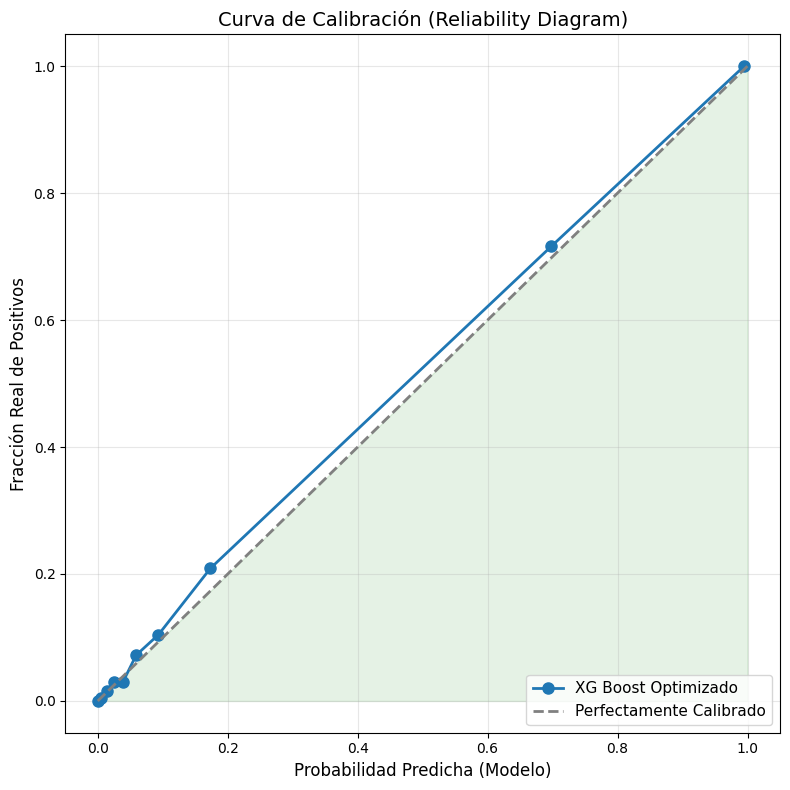

📏 Brier Score: 0.0517 (menor es mejor, 0 = perfecto)


In [23]:
# Curva de Calibración (Reliability Diagram)
prob_true, prob_pred = calibration_curve(
    y_test, y_prob, n_bins=10, strategy="quantile")

plt.figure(figsize=(8, 8))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2,
         markersize=8, label='XG Boost Optimizado')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray',
         linewidth=2, label='Perfectamente Calibrado')
plt.fill_between([0, 1], [0, 1], alpha=0.1, color='green')

plt.xlabel('Probabilidad Predicha (Modelo)', fontsize=12)
plt.ylabel('Fracción Real de Positivos', fontsize=12)
plt.title('Curva de Calibración (Reliability Diagram)', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Brier Score (menor es mejor, 0 = perfecto)
brier = brier_score_loss(y_test, y_prob)
print(f"📏 Brier Score: {brier:.4f} (menor es mejor, 0 = perfecto)")

In [24]:
# Calibrar usando Isotonic Regression (más flexible) o Sigmoid (Platt Scaling)

# Calibración Isotonic
calibrated_model_isotonic = CalibratedClassifierCV(model, method='isotonic', cv=5)

# Entrenar calibradores
calibrated_model_isotonic.fit(X_train, y_train)

# Probabilidades calibradas
y_prob_calibrated_isotonic = calibrated_model_isotonic.predict_proba(X_test)[:, 1]


In [25]:
# Calibrar usando sigmoid Regression (más flexible) o Sigmoid (Platt Scaling)

# Calibración sigmoid
calibrated_model_sigmoid = CalibratedClassifierCV(model, method='sigmoid', cv=5)

# Entrenar calibradores
calibrated_model_sigmoid.fit(X_train, y_train)

# Probabilidades calibradas
y_prob_calibrated_sigmoid = calibrated_model_sigmoid.predict_proba(X_test)[:, 1]

In [26]:
from sklearn.calibration import calibration_curve

# Modelo original
prob_true, prob_pred = calibration_curve(
    y_test, y_prob, n_bins=10, strategy="quantile"
)


# Isotonic
prob_true_iso, prob_pred_iso = calibration_curve(
    y_test, y_prob_calibrated_isotonic, n_bins=10, strategy="quantile"
)

# Sigmoid
prob_true_sig, prob_pred_sig = calibration_curve(
    y_test, y_prob_calibrated_sigmoid, n_bins=10, strategy="quantile"
)


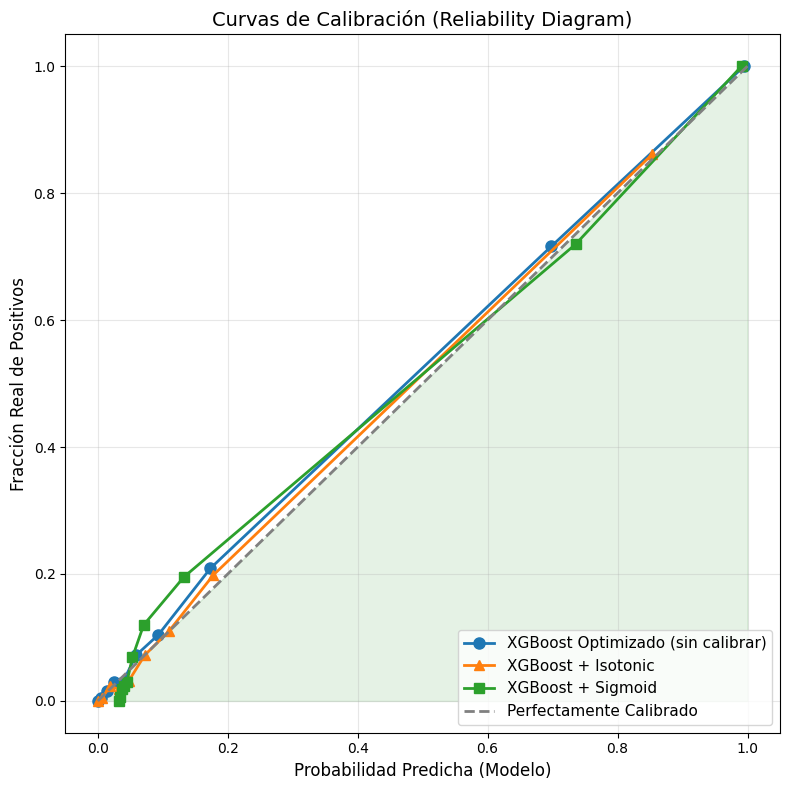

In [27]:
plt.figure(figsize=(8, 8))

# Modelo base
plt.plot(prob_pred, prob_true, marker='o', linewidth=2,
         markersize=8, label='XGBoost Optimizado (sin calibrar)')


# Isotonic
plt.plot(prob_pred_iso, prob_true_iso, marker='^', linewidth=2,
         markersize=7, label='XGBoost + Isotonic')

# Sigmoid
plt.plot(prob_pred_sig, prob_true_sig, marker='s', linewidth=2,
         markersize=7, label='XGBoost + Sigmoid')


# Línea perfecta
plt.plot([0, 1], [0, 1], linestyle='--', color='gray',
         linewidth=2, label='Perfectamente Calibrado')

plt.fill_between([0, 1], [0, 1], alpha=0.1, color='green')

plt.xlabel('Probabilidad Predicha (Modelo)', fontsize=12)
plt.ylabel('Fracción Real de Positivos', fontsize=12)
plt.title('Curvas de Calibración (Reliability Diagram)', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# Calcular Brier Score para cada modelo
brier_inicial = brier_score_loss(y_test, y_prob)
brier_isotonic = brier_score_loss(y_test, y_prob_calibrated_isotonic)
brier_sigmoid = brier_score_loss(y_test, y_prob_calibrated_sigmoid)

print("📏 BRIER SCORE (menor es mejor)\n")
print(f"🟠 Modelo inicial:    {brier_inicial:.4f}")
print(f"✅ Modelo calibrado con isotonic: {brier_isotonic:.4f}")
print(f"🟠 Modelo calibrado con sigmoid:   {brier_sigmoid:.4f}")


📏 BRIER SCORE (menor es mejor)

🟠 Modelo inicial:    0.0517
✅ Modelo calibrado con isotonic: 0.0515
🟠 Modelo calibrado con sigmoid:   0.0528


C:\Users\gurbina\AppData\Local\Temp\ipykernel_33780\1013131040.py:20: UserWarning:

Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.

c:\Users\gurbina\AppData\Local\miniconda3\envs\ml_pro_v2\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.



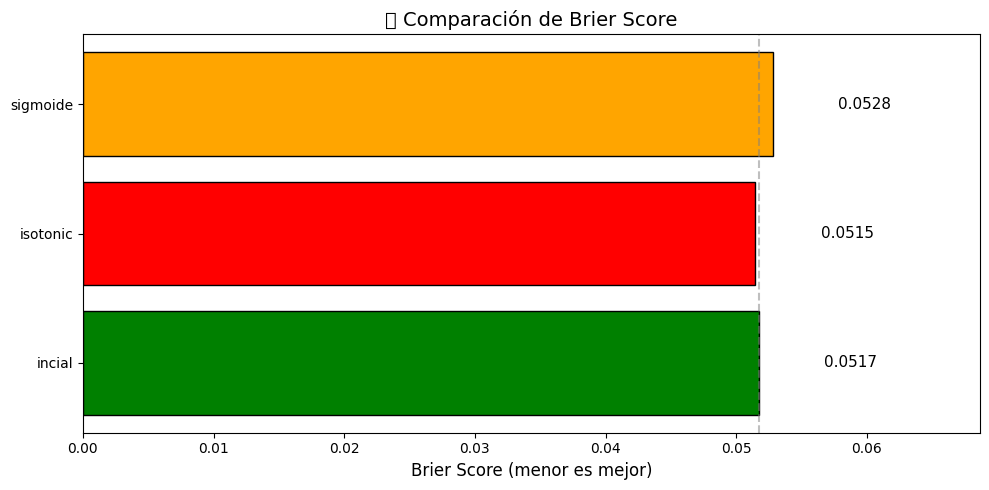

In [29]:
# Visualizar Brier Scores
modelos = ['incial', 'isotonic', 'sigmoide']
scores = [brier_inicial, brier_isotonic, brier_sigmoid]
colores = ['green', 'red', 'orange']

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(modelos, scores, color=colores, edgecolor='black')

# Añadir valores en las barras
for bar, score in zip(bars, scores):
    ax.text(score + 0.005, bar.get_y() + bar.get_height()/2,
            f'{score:.4f}', va='center', fontsize=11)

ax.set_xlabel('Brier Score (menor es mejor)', fontsize=12)
ax.set_title('📏 Comparación de Brier Score', fontsize=14)
ax.set_xlim([0, max(scores) * 1.3])
ax.axvline(brier_inicial, color='gray', linestyle='--',
           alpha=0.5, label='Umbral de ignorancia')

plt.tight_layout()
plt.show()

<div style="color:#800080; font-size:28px; font-weight:bold;">
    6. Selección de umbral optimo    
</div>

💰 Profit Curves: Hablando en Dólares (la matriz de confusión a dinero)

⚠️ Real-World Warning: El Negocio Manda (Cost-Sensitive Learning): Un AUC de 0.85 se ve bien en el paper, pero en el banco lo que importa es el **dinero**:
*   **Falso Positivo:** Rechazamos a un buen cliente → Perdemos intereses (Costo de Oportunidad).
*   **Falso Negativo:** Le prestamos a quien no paga → Perdemos el capital (Pérdida Directa).
*   **Regla de Oro:** Generalmente, un FN es **10x a 20x** más caro que un FP.
*   En producción, **NO usamos el umbral de 0.5**; movemos el umbral para minimizar el **Costo Esperado**.

Matriz de Costos (Ejemplo Bancario)

Un banco quiere predecir qué clientes caerán en **default** (no pagarán su préstamo).

| Escenario | Predicción | Realidad | ¿Qué pasa? |
|-----------|------------|----------|------------|
| **TN** (True Negative) | "Pagará" ✅ | Pagó ✅ | **Ganamos intereses** (+$500) |
| **TP** (True Positive) | "No pagará" ❌ | No pagó ❌ | **Evitamos pérdida** ($0) |
| **FP** (False Positive) | "No pagará" ❌ | Sí pagó ✅ | **Perdemos cliente** (-$100) |
| **FN** (False Negative) | "Pagará" ✅ | No pagó ❌ | **PERDEMOS TODO** (-$2,000) |

**Objetivo:** Encontrar el umbral de probabilidad (threshold) que maximice la ganancia total.

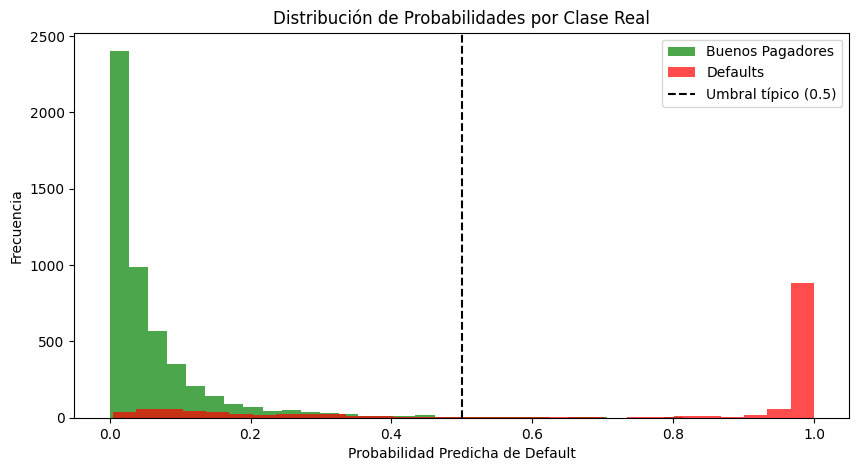

In [30]:
# Visualizar la distribución de probabilidades
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(y_prob[y_test == 0], bins=30, alpha=0.7,
        label='Buenos Pagadores', color='green')
ax.hist(y_prob[y_test == 1], bins=30, alpha=0.7, label='Defaults', color='red')

ax.axvline(0.5, color='black', linestyle='--', label='Umbral típico (0.5)')
ax.set_xlabel('Probabilidad Predicha de Default')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Probabilidades por Clase Real')
ax.legend()
plt.show()

Se evaluaron distintos umbrales entre 0.01 y 0.99. Para cada umbral se calculó el F1-score y su correspondiente matriz de confusión. El umbral óptimo se seleccionó como aquel que maximiza el F1-score, comparándose además con el umbral estándar de 0.5.

**Maximización de F1-Score (umbral estándar)** 

In [31]:

thresholds = np.linspace(0.01, 0.99, 100)

results_f1 = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_t)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    
    results_f1.append((f1, tn, fp, fn, tp))

# Extraer F1
f1_scores = [r[0] for r in results_f1]

# Óptimo
best_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_idx]
best_f1, best_tn, best_fp, best_fn, best_tp = results_f1[best_idx]

# Comparación con 0.5
y_pred_05 = (y_prob >= 0.5).astype(int)
f1_05 = f1_score(y_test, y_pred_05)
tn_05, fp_05, fn_05, tp_05 = confusion_matrix(y_test, y_pred_05).ravel()

# Resultados
print(f"🎯 Umbral óptimo por F1: {best_threshold_f1:.2f}")
print(f"📈 F1 máximo: {best_f1:.4f}")
print(
    f"📊 Matriz en óptimo: TN={best_tn}, FP={best_fp}, FN={best_fn}, TP={best_tp}"
)

print("\n📉 Comparación con threshold = 0.5")
print(f"   F1 con 0.5: {f1_05:.4f}")
print(
    f"   Matriz 0.5: TN={tn_05}, FP={fp_05}, FN={fn_05}, TP={tp_05}"
)

🎯 Umbral óptimo por F1: 0.46
📈 F1 máximo: 0.8301
📊 Matriz en óptimo: TN=5050, FP=45, FN=381, TP=1041

📉 Comparación con threshold = 0.5
   F1 con 0.5: 0.8288
   Matriz 0.5: TN=5063, FP=32, FN=393, TP=1029


**Maximización del beneficio esperado (usando la matriz de costos definida)** 

In [32]:

# Definir la matriz de costos (ajustar según el negocio)
BENEFIT_TN = 500    # Ganancia por aprobar buen crédito
COST_FN = -2000     # Pérdida por aprobar mal crédito (default)
COST_FP = -100      # Pérdida por rechazar buen cliente
BENEFIT_TP = 0      # Evitar pérdida (ganancia 0)


def calculate_profit(y_true, y_prob, threshold):

    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    total_profit = ( 
    (tn * BENEFIT_TN) + 
    (fn * COST_FN) + 
    (fp * COST_FP) + 
    (tp * BENEFIT_TP)
    )
    return total_profit, tn, fp, fn, tp


# Calcular profit para múltiples thresholds
thresholds = np.linspace(0.01, 0.99, 99)
results = [calculate_profit(y_test, y_prob, t) for t in thresholds]
profits = [r[0] for r in results]

# Encontrar el óptimo
best_idx = np.argmax(profits)
max_profit = profits[best_idx]
best_threshold = thresholds[best_idx]
_, best_tn, best_fp, best_fn, best_tp = results[best_idx]

# Comparar con threshold por defecto (0.5)
profit_default, tn_05, fp_05, fn_05, tp_05 = calculate_profit(
    y_test, y_prob, 0.5)

print(f"💰 Ganancia Máxima: ${max_profit:,.0f}")
print(f"🎯 Umbral Óptimo: {best_threshold:.2f}")
print(
    f"📊 Matriz en óptimo: TN={best_tn}, FP={best_fp}, FN={best_fn}, TP={best_tp}")
print(f"\n📉 Comparación con threshold=0.5:")
print(f"   Ganancia con 0.5: ${profit_default:,.0f}")
print(
    f"   Diferencia: ${max_profit - profit_default:+,.0f} ({(max_profit/profit_default - 1)*100:+.1f}%)")

💰 Ganancia Máxima: $1,855,900
🎯 Umbral Óptimo: 0.22
📊 Matriz en óptimo: TN=4829, FP=266, FN=266, TP=1156

📉 Comparación con threshold=0.5:
   Ganancia con 0.5: $1,742,300
   Diferencia: $+113,600 (+6.5%)


**Comparando métricas en el umbral base y los 2 umbrales que se obtuvieron arriba** 

In [33]:
def calcular_metricas(y_test, y_prob, threshold):
    """Calcula métricas para un umbral dado."""
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return {
        'threshold': threshold,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }


# Comparar 3 umbrales
for t in [0.5, 0.39, 0.22]:
    m = calcular_metricas(y_test, y_prob, t)
    print(f"\n📊 Umbral = {t}")
    print(f"   Accuracy: {m['accuracy']:.2%}")
    print(f"   Precision: {m['precision']:.2%}")
    print(f"   Recall: {m['recall']:.2%}")
    print(f"   Matriz: TN={m['tn']}, FP={m['fp']}, FN={m['fn']}, TP={m['tp']}")


📊 Umbral = 0.5
   Accuracy: 93.48%
   Precision: 96.98%
   Recall: 72.36%
   Matriz: TN=5063, FP=32, FN=393, TP=1029

📊 Umbral = 0.39
   Accuracy: 93.14%
   Precision: 93.03%
   Recall: 74.12%
   Matriz: TN=5016, FP=79, FN=368, TP=1054

📊 Umbral = 0.22
   Accuracy: 91.84%
   Precision: 81.29%
   Recall: 81.29%
   Matriz: TN=4829, FP=266, FN=266, TP=1156


**💰 Calculando la Ganancia (Profit)**

Convertimos la matriz de confusión en **dinero**.

```python
Profit = (TN × Beneficio_TN) + (TP × Beneficio_TP) + (FP × Costo_FP) + (FN × Costo_FN)

In [34]:
def calcular_profit(y_true, y_prob, threshold):
    """Calcula el profit total para un umbral dado."""
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    profit = (tn * BENEFIT_TN) + (tp * BENEFIT_TP) + \
        (fp * COST_FP) + (fn * COST_FN)
    return profit, tn, fp, fn, tp


# Comparar el profit para diferentes umbrales
print("💵 COMPARACIÓN DE GANANCIAS\n")
for t in [0.5, 0.39, 0.22]:
    profit, tn, fp, fn, tp = calcular_profit(y_test, y_prob, t)
    print(f"Umbral {t}: Profit = ${profit:,.0f}")
    print(
        f"   Desglose: TN={tn}(+${tn*BENEFIT_TN:,}), FP={fp}(${fp*COST_FP:,}), FN={fn}(${fn*COST_FN:,}), TP={tp}")
    print()

💵 COMPARACIÓN DE GANANCIAS

Umbral 0.5: Profit = $1,742,300
   Desglose: TN=5063(+$2,531,500), FP=32($-3,200), FN=393($-786,000), TP=1029

Umbral 0.39: Profit = $1,764,100
   Desglose: TN=5016(+$2,508,000), FP=79($-7,900), FN=368($-736,000), TP=1054

Umbral 0.22: Profit = $1,855,900
   Desglose: TN=4829(+$2,414,500), FP=266($-26,600), FN=266($-532,000), TP=1156



<div style="color:#800080; font-size:28px; font-weight:bold;">
    7. Curva de rentabilidad    
</div>

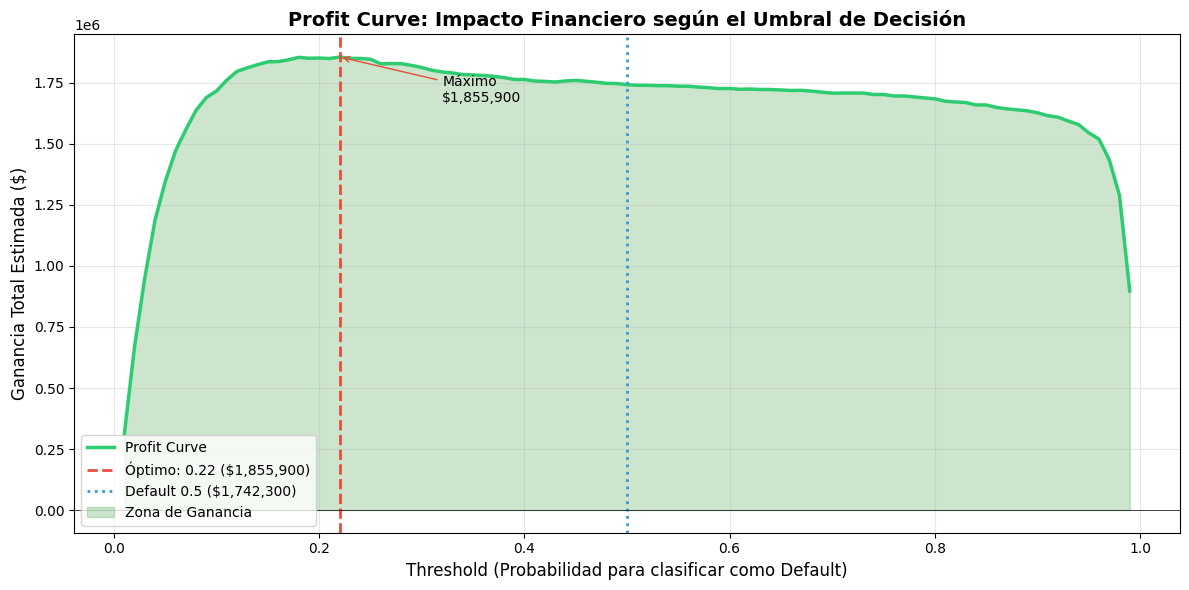

In [35]:
# Visualizar la Curva de Ganancia
fig, ax = plt.subplots(figsize=(12, 6))

# Profit curve
ax.plot(thresholds, profits, label='Profit Curve',
        color='#2ecc71', linewidth=2.5)

# Líneas de referencia
ax.axvline(best_threshold, color='#e74c3c', linestyle='--', linewidth=2,
           label=f'Óptimo: {best_threshold:.2f} (${max_profit:,.0f})')
ax.axvline(0.5, color='#3498db', linestyle=':', linewidth=2,
           label=f'Default 0.5 (${profit_default:,.0f})')
ax.axhline(0, color='black', linewidth=0.5)

# Sombrear zona de ganancia
ax.fill_between(thresholds, profits, 0, where=[p > 0 for p in profits],
                alpha=0.2, color='green', label='Zona de Ganancia')

ax.set_title('Profit Curve: Impacto Financiero según el Umbral de Decisión',
             fontsize=14, fontweight='bold')
ax.set_xlabel(
    'Threshold (Probabilidad para clasificar como Default)', fontsize=12)
ax.set_ylabel('Ganancia Total Estimada ($)', fontsize=12)
ax.legend(loc='lower left', fontsize=10)
ax.grid(True, alpha=0.3)

# Anotación del punto óptimo
ax.annotate(f'Máximo\n${max_profit:,.0f}',
            xy=(best_threshold, max_profit),
            xytext=(best_threshold + 0.1, max_profit * 0.9),
            fontsize=10, ha='left',
            arrowprops=dict(arrowstyle='->', color='#e74c3c'))

plt.tight_layout()
plt.show()

In [36]:
# Calcular profit para 100 umbrales
thresholds = np.linspace(0.01, 0.99, 100)
profits = [calcular_profit(y_test, y_prob, t)[0] for t in thresholds]

# Encontrar el óptimo
idx_optimo = np.argmax(profits)
threshold_optimo = thresholds[idx_optimo]
profit_optimo = profits[idx_optimo]

# También calcular profit con umbral default (0.5)
profit_default = calcular_profit(y_test, y_prob, 0.5)[0]

print(f"🎯 Umbral Óptimo: {threshold_optimo:.2f}")
print(f"💰 Profit Máximo: ${profit_optimo:,.0f}")
print(f"📉 Profit con umbral 0.5: ${profit_default:,.0f}")
print(f"📈 Diferencia: ${profit_optimo - profit_default:,.0f} ({(profit_optimo - profit_default) / abs(profit_default) * 100:.1f}% más)")


🎯 Umbral Óptimo: 0.21
💰 Profit Máximo: $1,855,700
📉 Profit con umbral 0.5: $1,742,300
📈 Diferencia: $113,400 (6.5% más)


**¿A qué porcentaje de la población deberíamos aplicar la acción?**

La acción rechazar el crédito debe aplicarse a los clientes cuya probabilidad predicha de default es mayor o igual al umbral óptimo encontrado (≈ 0.22).
Esto corresponde aproximadamente al 22% de la población, que concentra el mayor riesgo de incumplimiento.
Actuar únicamente sobre este segmento permite focalizar la intervención, evitando costos innecesarios sobre clientes de bajo riesgo.

**¿Cuál es el beneficio máximo esperado? - Comparación con estrategia aleatoria**

El beneficio máximo esperado se obtiene al utilizar el umbral óptimo ≈ 0.22, y es significativamente mayor que el beneficio obtenido con el umbral estándar 0.5.
Este beneficio máximo surge de:
Reducir fuertemente los falsos negativos (defaults aprobados)
Aceptar un número controlado de falsos positivos (buenos clientes rechazados)


En términos económicos, esta estrategia maximiza el valor esperado total, alineando el modelo con los objetivos del negocio.


<div style="color:#800080; font-size:28px; font-weight:bold;">
    8. Conclusiones y Recomendaciones
</div>

**Resumen de mejoras obtenidas en cada etapa**

MODELO BASE
- Se evaluaron Random Forest, Gradient Boosting, XGBoost y LightGBM
- XGBoost mostró el mejor equilibrio entre AUC y recall

OPTIMIZACIÓN CON OPTUNA
- Mejora en AUC mediante búsqueda eficiente de hiperparámetros
- Uso de cross-validation y pruning para eficiencia

CALIBRACIÓN DE PROBABILIDADES
- Se aplicaron métodos Isotonic y Sigmoid
- Reducción del Brier Score, mejorando la confiabilidad de las probabilidades

OPTIMIZACIÓN DEL UMBRAL
- Se dejó de usar el umbral 0.5
- Se seleccionó el umbral que maximiza el beneficio económico
- Incremento claro del beneficio esperado


**Recomendación final: ¿Qué modelo, umbral y estrategia usar en producción?**

- EL modelo a usar debe ser XGBoost optimizado con Optuna
- Calibrado (preferentemente Isotonic si hay suficientes datos)
- Con Umbral de decisión: 0.22, seleccionado por maximización de beneficio económico

Aplicar acciones solo al segmento de mayor riesgo (22% de la población)
Esta combinación maximiza el beneficio esperado, reduce pérdidas por defaults y mantiene controlados los costos de oportunidad.


**Limitaciones y próximos pasos**



**próximos pasos**

Explorar los Modelos Ensamblados Avanzados ((Stacking, Blending) para ver si podría haber mejora incremental, sin hacerlo tan complejo, ni dificil de mantener en produción, y siempre en cuando garantice beneficios economicos adicionales.



<div style="color:#800080; font-size:28px; font-weight:bold;">
    9. Referencias
</div>

El caso se ha tomado de kaggle:  


https://www.kaggle.com/datasets/laotse/credit-risk-dataset

<div style="color:#800080; font-size:28px; font-weight:bold;">
    10. Serialización y Producción (Adicional)
</div>

**Como punto adicional, se ha generado el joblib y se realizó el deploy en producción. Para su Verificación se puede realizar desde el siguiente link:**

https://pecd-supervisado-ctrl3.streamlit.app/


In [37]:
import sys
import os
import json
import sklearn

# ========================================
# MÉTODO 2: JOBLIB (Estándar ML)
# ========================================
joblib_path = '../app/models/model_joblib.joblib'
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Guardar CON metadatos (buena práctica)
artifact = {
    'model': model,
    'feature_names': X.columns.tolist(),
    'target_col': TARGET_COL,
    'auc_test': auc,
    'training_date': pd.Timestamp.now().isoformat(),
    'python_version': xgb.__version__
    #'lightgbm_version': lgb.__version__
}

start = time.time()
joblib.dump(artifact, joblib_path, compress=3)  # compress=3 es buen balance
joblib_save_time = time.time() - start

# Cargar
start = time.time()
loaded_artifact = joblib.load(joblib_path)
joblib_load_time = time.time() - start

model_joblib = loaded_artifact['model']

# Verificar
pred_joblib = model_joblib.predict_proba(X_test)[:, 1]
auc_joblib = roc_auc_score(y_test, pred_joblib)

joblib_size = os.path.getsize(joblib_path) / 1024

print(f"📁 Archivo: {joblib_path}")
print(f"📦 Tamaño: {joblib_size:.2f} KB (comprimido)")
print(f"⏱️ Tiempo guardar: {joblib_save_time*1000:.2f} ms")
print(f"⏱️ Tiempo cargar: {joblib_load_time*1000:.2f} ms")
print(f"✅ AUC verificado: {auc_joblib:.4f}")
print(f"\n📋 Metadatos guardados: {list(loaded_artifact.keys())}")

📁 Archivo: ../app/models/model_joblib.joblib
📦 Tamaño: 1718.97 KB (comprimido)
⏱️ Tiempo guardar: 128.81 ms
⏱️ Tiempo cargar: 43.79 ms
✅ AUC verificado: 0.9519

📋 Metadatos guardados: ['model', 'feature_names', 'target_col', 'auc_test', 'training_date', 'python_version']


In [38]:
# ========================================
# MÉTODO 5B: JSON + Metadatos (Para APIs)
# ========================================
json_path = '../app/models/model_metadata.json'

# Guardar metadatos en JSON (legible por cualquier lenguaje)
metadata = {
    'model_type': 'XGBoost',
    'model_file': 'model_texto.txt',
    'feature_names': X.columns.tolist(),
    'n_features': len(X.columns.tolist()),
    'target_col': TARGET_COL,
    
    'metrics': {
        'auc_test': round(auc, 4),
        'n_train_samples': len(X_train),
        'n_test_samples': len(X_test)
    },
    
    'training_info': {
        'date': pd.Timestamp.now().isoformat(),
        'version': xgb.__version__        
    }
}

with open(json_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"📁 Metadatos guardados: {json_path}")
print(f"\n📋 Contenido:")
print(json.dumps(metadata, indent=2)[:1000] + "...")

📁 Metadatos guardados: ../app/models/model_metadata.json

📋 Contenido:
{
  "model_type": "XGBoost",
  "model_file": "model_texto.txt",
  "feature_names": [
    "person_age",
    "person_income",
    "person_home_ownership",
    "person_emp_length",
    "loan_intent",
    "loan_grade",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_default_on_file",
    "cb_person_cred_hist_length"
  ],
  "n_features": 11,
  "target_col": "loan_status",
  "metrics": {
    "auc_test": 0.9519,
    "n_train_samples": 26064,
    "n_test_samples": 6517
  },
  "training_info": {
    "date": "2025-12-15T08:47:57.790179",
    "version": "3.1.2"
  }
}...
